In [1]:
# %load prepareStats.py
#!/usr/bin/env python

"""
Don't repeat yourself, they say. So this is the stuff that goes in the beginning of all my 
Jupyter Notebooks exploring various F1 statistics. https://github.com/michalkasparek/f1-stats/
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Let's define some useful lists first

unknownResult = ["nan0n", "NaN", "NA", "inf"]
crashes = ["Accident", "Collision", "Fatal accident", "Collision damage", "Spun off"]
dnqs = ["Did not qualify", "Did not prequalify", "107% Rule"]

Europe = ["Austria", "Austrian", "Azerbaijan", "Belgian", "Belgium", "British", "Czech", "Danish", "Dutch", "East German", "Finnish", "France", "French", "German", "Germany", "Hungarian", "Hungary", "Irish", "Italian", "Italy", "Liechtensteiner", "Monaco", "Monegasque", "Netherlands", "Polish", "Portugal", "Portuguese", "Russia", "Russian", "Spanish", "Spain", "Sweden", "Swedish", "Swiss", "Switzerland", "Turkey", "UK"]
NAmerica = ["American", "Canada", "Canadian", "Mexican", "Mexico", "USA"]
SAmerica = ["Argentina", "Argentine", "Brazil", "Brazilian", "Chilean", "Colombian", "Uruguayan", "Venezuelan"]
Asia = ["Bahrain", "Chinese", "China", "Hong Kong", "India", "Indian", "Indonesian", "Japan", "Japanese", "Korea", "Malaysia", "Malaysian", "Qatar", "Saudi Arabia", "Singapore", "Thai", "UAE"]
Africa = ["Morocco", "Rhodesian", "South Africa", "South African"]
Oceania = ["Australia", "Australian", "New Zealander"]
multiple = ["American-Italian", "Argentine-Italian"]
westernEurope = ["Austria", "Belgium", "Germany", "France", "Italy", "Monaco", "Netherlands", "Portugal", "Spain", "Sweden", "Switzerland", "UK"]

streetCircuits = ["Melbourne", "Monte-Carlo", "Montreal", "Valencia", "Marina Bay", "Sochi", "Baku", "Jeddah", "Adelaide", "Phoenix", "Detroit", "Dallas", "Nevada", "California", "Oporto", "Lisbon"]

# Now we're gonna load the stats… (source: http://ergast.com/mrd/db/#csv)

drivers = pd.read_csv(os.path.join("data", "drivers.csv"))
results = pd.read_csv(os.path.join("data", "results.csv"))
races = pd.read_csv(os.path.join("data", "races.csv"))
circuits = pd.read_csv(os.path.join("data", "circuits.csv"))
status = pd.read_csv(os.path.join("data", "status.csv"))
constructors = pd.read_csv(os.path.join("data", "constructors.csv"))

# …merge all the tables into a single dataframe…

results = results.merge(drivers, on="driverId", how="right")
races = races.merge(circuits, on="circuitId", how="right")
results = results.merge(races, on="raceId", how="right")
results = results.merge(status, on="statusId", how="right")
results = results.merge(constructors, on="constructorId", how="right")

# …make the columns more useful…

results["fullname"] = results["forename"] + " " + results["surname"]
results["date"] = pd.to_datetime(results["date"], format="%Y-%m-%d")
results["year"] = results["year"].apply(pd.to_numeric, errors = "coerce").astype(np.int64, errors="ignore")
results["round"] = results["round"].apply(pd.to_numeric, errors = "coerce").astype(np.int64, errors="ignore")
results["position"] = results["position"].apply(pd.to_numeric, errors = "coerce").astype(np.int64, errors="ignore")
results["fastestLapSpeed"] = results["fastestLapSpeed"].apply(pd.to_numeric, errors = "coerce").astype(np.int64, errors="ignore")

# …and create some new columns.

results["year_round"] = results["year"].astype(str).str.slice(0,4) + results["round"].astype(str).str.slice(0,-2).str.zfill(2)
results = results[~results.year_round.isin(unknownResult)]
results["year_round"] = results["year_round"].apply(pd.to_numeric, errors = "coerce").astype(int)

results.loc[results.nationality_x.isin(Europe),"driverContinent"]="Europe"
results.loc[results.nationality_x.isin(NAmerica),"driverContinent"]="NAmerica"
results.loc[results.nationality_x.isin(SAmerica),"driverContinent"]="SAmerica"
results.loc[results.nationality_x.isin(Asia),"driverContinent"]="Asia"
results.loc[results.nationality_x.isin(Africa),"driverContinent"]="Africa"
results.loc[results.nationality_x.isin(Oceania),"driverContinent"]="Oceania"
results.loc[results.nationality_x.isin(multiple),"driverContinent"]="multiple"

results.loc[results.location.isin(streetCircuits),"street"]=True

entries = pd.Series(results.groupby(["driverId"]).size(), name="entries")
results = results.merge(entries, on = ["driverId"], how = "right")

# Now split the main dataframe for wins, podiums and top 6 finishes only 

wins = results[results["position"] == 1]
podiums = results[results["position"] < 4]
top6 = results[results["position"] < 7]

# Finally let's give the plots some swag

plt.style.use("_mpl-gallery")
plt.rcParams["figure.figsize"] = (20,3)

C:\Users\micha\AppData\Local\Temp\ipykernel_17908\1151300188.py:46: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  results = results.merge(constructors, on="constructorId", how="right")
C:\Users\micha\AppData\Local\Temp\ipykernel_17908\1151300188.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["year_round"] = results["year_round"].apply(pd.to_numeric, errors = "coerce").astype(int)
C:\Users\micha\AppData\Local\Temp\ipykernel_17908\1151300188.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

## Drivers with the most race-ending crashes and the highest race-ending crash ratios 

In [2]:
crashDNF = results[(results.status.isin(crashes))]

In [3]:
driversMostCrashes = crashDNF.groupby("fullname").size()

In [4]:
driversMostCrashes.nlargest(10)

fullname
Andrea de Cesaris       37
Riccardo Patrese        36
David Coulthard         32
Rubens Barrichello      32
Giancarlo Fisichella    30
Jean Alesi              30
Johnny Herbert          30
Michael Schumacher      30
Ukyo Katayama           30
Jarno Trulli            29
dtype: int64

In [5]:
carnageExperts = results[(results.status.isin(crashes)) & (results.entries >= 10)].groupby(["surname", "forename"]).size() / results.groupby(["surname", "forename"]).size()

In [6]:
carnageExperts.nlargest(10)

surname    forename
Andretti   Michael     0.461538
Brise      Tony        0.400000
Inoue      Taki        0.333333
Tuero      Esteban     0.312500
Katayama   Ukyo        0.309278
Chiesa     Andrea      0.300000
Lavaggi    Giovanni    0.300000
Scheckter  Ian         0.300000
Blundell   Mark        0.285714
Pantano    Giorgio     0.285714
dtype: float64

## The most challenging circuits in the Lewis Hamilton era

In [7]:
pd.options.display.float_format = '{:.2%}'.format

In [8]:
resultsLHera = results[results["year"] > 2006]

circuitsLHEResults = resultsLHera.groupby(["location"]).size()

In [9]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2006]

circuitsDNFLHera = crashDNFLHera.groupby(["location"]).size()

In [10]:
circuitsLHeraGPs = resultsLHera.groupby(["location"])["year_round"].nunique()

In [11]:
mergedCircuitStats = pd.concat([circuitsLHeraGPs, circuitsLHEResults, circuitsDNFLHera], axis=1, keys=["circuitsLHeraGPs", "circuitsLHEResults", "circuitsDNFLHera"])

In [12]:
mergedCircuitStats["ratio"] =  mergedCircuitStats["circuitsDNFLHera"] / mergedCircuitStats["circuitsLHEResults"]

In [13]:
mergedCircuitStats["ratio"].sort_values(ascending=False).head(5)

location
Mugello          30.00%
Indianapolis     18.18%
Jeddah           17.50%
Yeongam County   15.96%
Oyama            14.29%
Name: ratio, dtype: float64

In [14]:
frequentCircuitStats = mergedCircuitStats[mergedCircuitStats["circuitsLHeraGPs"] > 2]

In [15]:
frequentCircuitStats["ratio"].sort_values(ascending=False).nlargest(10)

location
Yeongam County   15.96%
Monte-Carlo      14.06%
Melbourne        11.67%
Marina Bay       11.24%
Baku             10.78%
Montreal         10.77%
Silverstone       9.71%
São Paulo         9.46%
Spa               8.75%
Sochi             8.59%
Name: ratio, dtype: float64

## On what lap do the crashes occur?

Todo: calculate a race progress percentage and work with it rather than with a lap count.

In [16]:
crashDNFLHera = crashDNF[crashDNF["year"] > 2001]

In [17]:
whatLap = crashDNFLHera[["laps"]]

In [18]:
howManyBins = crashDNFLHera[["laps"]].max()

array([[<AxesSubplot:title={'center':'laps'}>]], dtype=object)

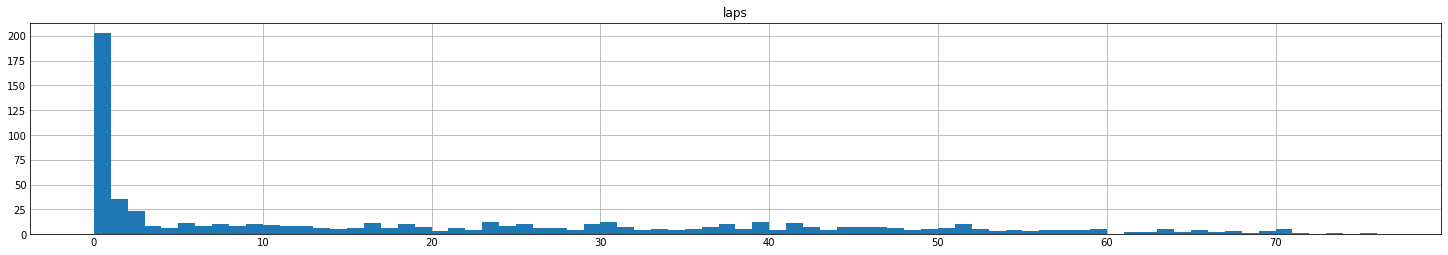

In [19]:
whatLap.hist(bins = 76)